In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
import itertools
import warnings
warnings.filterwarnings('ignore')

print("Loading...")
followers_df_all = pd.read_table('./input/user_sns.txt', names=('follower', 'followee'))
print("Loaded")

id_from = 1000000
#id_to = 1100000
id_to = 1025000 #10 gruop
id_to = 1021000 #5 gruop
limit = 5

a = followers_df_all[followers_df_all["followee"] > id_from]
b = a[a["followee"] <= id_to]
c = b[b["follower"] > id_from]
followers_df = c[c["follower"] <= id_to]

#users who belongs to a group whose size is greater than or equal to 5
followers_count_df = followers_df.groupby(['follower']).size()
followers_with_enough_followees_df = followers_count_df[ followers_count_df >= limit].reset_index()[['follower']]
selected_df =  followers_df.merge(followers_with_enough_followees_df,
               how = 'right',
               left_on = 'follower',
               right_on = 'follower')

groups = selected_df.groupby('follower')['followee'].apply(list)
groups_comb = selected_df.groupby('follower')['followee'].apply(list)
groups_df = pd.DataFrame(groups).reset_index()
#groups_df.to_csv("../out/tx_log.csv", index=True, header=False)

groups_for_viz = groups.copy()

# append self
for send_from in groups.keys():
    groups[send_from].append(send_from)
    groups_comb[send_from].append(send_from)



# extract all possible pairs in the group
for send_from in groups.keys():
  groups[send_from] = list(itertools.permutations(groups[send_from],2))
  groups_comb[send_from] = list(itertools.combinations(groups_comb[send_from],2))

pairs = []
for send_from in groups.keys():
    pairs.extend(groups[send_from])

sender_receiver = pd.DataFrame(pairs, columns= ["sender","receiver"]); sender_receiver["count"] = 1
pivot_table = sender_receiver.pivot_table(values="count",index='sender', columns='receiver', aggfunc = 'count').fillna(0)
pivot_matrix = pivot_table.values

# Matrix Factorization by SVD (Singular Value Decomposition)
NUMBER_OF_FACTORS_MF = int(pivot_table.shape[0] * (0.1))
U, sigma, Vt = svds(pivot_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma), Vt)
svd_preds_df = pd.DataFrame(predicted_ratings, columns = pivot_table.columns, index=pivot_table.index)

res = pd.DataFrame(columns=['related_clients'])
for client_id in svd_preds_df.keys():
    sorted_client_predictions = list(svd_preds_df[client_id].sort_values(ascending=False).keys())
    res.loc[client_id] = [sorted_client_predictions]

#res.to_csv('../out/relationship.csv', header = False, index=True)
print("Done")

Loading...
Loaded
Done


In [3]:
edges = set()
tmp_nodes = set()
for rep in groups_for_viz.keys():
    tmp_nodes.add(rep)
    for other in groups_for_viz[rep]:
        edges.add((rep,other))
        tmp_nodes.add(other)
edges = list(edges)

clients_df = pd.read_csv("clientCache.csv", names = ["application_id", "client_id", "x", "y", "home_id"])
nodes = list()
for i in range(len(clients_df)):
    if clients_df.iloc[i]["client_id"] in tmp_nodes:
        nodes.append((clients_df.iloc[i]["client_id"], {"pos" : [clients_df.iloc[i]["x"], clients_df.iloc[i]["y"]]}))

In [4]:
edges = set()
for g in groups_comb:
    for p in g:
        edges.add(p)
        tmp_nodes.add(p[0]); tmp_nodes.add(p[1])
edges = list(edges)

clients_df = pd.read_csv("clientCache.csv", names = ["application_id", "client_id", "x", "y", "home_id"])
nodes = list()
for i in range(len(clients_df)):
    if clients_df.iloc[i]["client_id"] in tmp_nodes:
        nodes.append((clients_df.iloc[i]["client_id"], {"pos" : [clients_df.iloc[i]["x"], clients_df.iloc[i]["y"]]}))

In [28]:
import plotly.graph_objects as go

import networkx as nx
import psutil

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.0, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                titlefont_size=16,
                font_size=24,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                width = 1000,
                height = 1000,
                #annotations=[ dict(
                #    showarrow=False,
                #    xref="paper", yref="paper",
                #    x=0.005, y=-0.002 ) ],
                xaxis=dict(range=[0,100],showgrid=True, zeroline=True, showticklabels=True),
                yaxis=dict(range=[0,100],showgrid=True, zeroline=True, showticklabels=True))
                )
fig.show()
fig.to_image(format="png", engine="kaleido")
print("saving...")
fig.write_image("group5_limit5.png")

saving...


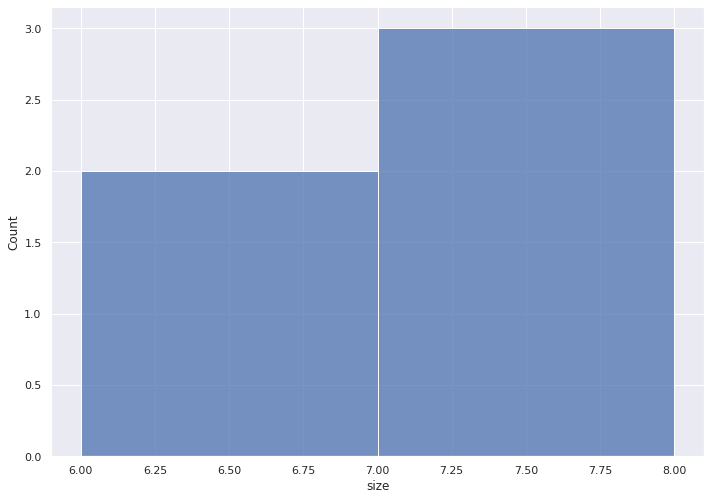

In [32]:
import seaborn as sns

groups_df["size"] = 0
for i, row in enumerate(groups_df["followee"]):
    groups_df["size"][i] = len(row)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data = groups_df, x = "size", binwidth = 1)
ax.figure.savefig("group5_limit5_hist.png")